![title](imgs/cover.png)

# Machine Learning Model
A terceira etapa do projeto envolve a modelagem de machine learning, onde inicialmente os dados são importados de fontes predeterminadas. Segue-se a preparação desses dados, um processo que inclui a codificação de variáveis categóricas e a normalização de variáveis numéricas para manter a consistência e relevância nos modelos de machine learning. Além disso, os dados são divididos em conjuntos de treino e teste, e realiza-se a seleção de características importantes. Posteriormente, diversos modelos são aplicados para avaliar qual apresenta melhor desempenho inicial, selecionando os três principais para análises mais profundas. Estes modelos são então submetidos a uma avaliação rigorosa, onde métricas como acurácia e a área sob a curva ROC são analisadas para identificar os mais eficazes. Após esta análise, um ajuste fino dos hiperparâmetros é realizado para otimizar o desempenho dos modelos. Finalmente, os modelos ajustados e os artefatos relevantes são exportados para uso futuro ou implementação.

---

In [1]:
import os
import time
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import visualizer 

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from joblib import dump

import warnings
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
warnings.filterwarnings("ignore")

---
# Importação dos Dados
Os dados para o modelo de machine learning serão importados. O processo inclui carregar conjuntos de dados a partir de arquivos ou fontes externas, garantindo que os dados estejam acessíveis e prontos para as etapas subsequentes de pré-processamento e modelagem.

In [2]:
# Dicionário para armazenar os tempos de execução
time_report = {}

In [3]:
# Import data
df = pd.read_csv('data/cleaned_test_data.csv', sep = ';')

In [4]:
print(df.shape)
df.head()

(585340, 14)


,country,creation_platform,admin_visits,intercom_conversations,source_pulido,creation_weekday,creation_hour,products_with_description,total_products_with_images,total_product_categories,total_events_on_Android,total_events_on_Web,total_events_on_iOS,target
0,BR,mobile_app,1.0,0.0,Other,6,3,2.0,1,0.0,215.0,6.0,0.0,0
1,BR,mobile_web,2.0,0.0,Google CPC no Brand,6,3,1.0,1,0.0,0.0,44.0,0.0,0
2,BR,mobile_web,1.0,0.0,Google CPC no Brand,6,3,0.0,0,0.0,0.0,16.0,0.0,0
3,BR,mobile_web,1.0,0.0,Google CPC no Brand,6,3,0.0,0,0.0,0.0,15.0,0.0,0
4,BR,mobile_web,1.0,0.0,Google CPC no Brand,6,3,0.0,0,0.0,0.0,24.0,0.0,0


In [5]:
df = df.sample(10000)

---
# Preparação dos Dados
Esta etapa aborda o pré-processamento dos dados. Inclui a transformação de variáveis categóricas usando técnicas como o ordinal encoding, normalização de variáveis numéricas para garantir que a escala não afete o desempenho do modelo, divisão dos dados em conjuntos de treino e teste para validação futura, e seleção de características (feature selection) para melhorar a eficiência do modelo.

In [6]:
# Checando quais colunas são do tipo 'object', indicando variáveis categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['country', 'creation_platform', 'source_pulido'], dtype='object')

In [7]:
# Identificando colunas numéricas (int e float)
numeric_columns = df.select_dtypes(include=['int64', 'float64']).drop(columns='target').columns
numeric_columns

Index(['admin_visits', 'intercom_conversations', 'creation_weekday',
       'creation_hour', 'products_with_description',
       'total_products_with_images', 'total_product_categories',
       'total_events_on_Android', 'total_events_on_Web',
       'total_events_on_iOS'],
      dtype='object')

In [8]:
# Inicializando o codificador ordinal
encoder = OrdinalEncoder()

# Codificando as variáveis categóricas
df[categorical_columns] = encoder.fit_transform(df[categorical_columns])

# Exibindo o DataFrame com as variáveis categóricas codificadas
df.head()

,country,creation_platform,admin_visits,intercom_conversations,source_pulido,creation_weekday,creation_hour,products_with_description,total_products_with_images,total_product_categories,total_events_on_Android,total_events_on_Web,total_events_on_iOS,target
151067,0.0,2.0,1.0,0.0,0.0,0,11,0.0,0,0.0,0.0,52.0,0.0,0
192616,1.0,2.0,1.0,0.0,2.0,3,20,0.0,0,0.0,0.0,24.0,0.0,0
194747,1.0,2.0,1.0,0.0,2.0,6,6,0.0,0,0.0,0.0,23.0,0.0,0
128310,0.0,2.0,1.0,0.0,7.0,4,16,0.0,0,0.0,0.0,22.0,0.0,0
579945,0.0,0.0,1.0,0.0,6.0,3,15,1.0,1,0.0,0.0,8.0,0.0,0


In [9]:
# Definindo as variáveis independentes e a variável dependente (target)
X = df.drop('target', axis=1)
y = df['target']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [10]:
# Inicializando o StandardScaler
scaler = StandardScaler()

# Aplicando padronização nas colunas numéricas
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Exibindo o DataFrame com as colunas numéricas padronizadas
X_train.head()

,country,creation_platform,admin_visits,intercom_conversations,source_pulido,creation_weekday,creation_hour,products_with_description,total_products_with_images,total_product_categories,total_events_on_Android,total_events_on_Web,total_events_on_iOS
537634,0.0,2.0,-0.162889,-0.071664,0.0,-1.403140,-1.163980,-0.053906,-0.077705,-0.188791,-0.204663,-0.010394,-0.073609
353822,1.0,0.0,-0.162889,-0.071664,3.0,-0.373582,0.354521,-0.043011,-0.061589,-0.188791,-0.204663,-0.001661,-0.073609
21932,0.0,2.0,-0.162889,-0.071664,2.0,1.170754,-1.163980,-0.043011,-0.061589,-0.188791,-0.204663,-0.307334,-0.073609
451695,0.0,2.0,-0.162889,-0.071664,0.0,-0.373582,0.354521,-0.053906,-0.077705,-0.188791,-0.204663,-0.307334,-0.073609
569973,0.0,0.0,1.661465,-0.071664,6.0,0.141196,-1.440071,-0.053906,-0.077705,-0.188791,-0.204663,-0.578073,-0.073609


In [11]:
# Instanciando o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Obtendo a importância das características
feature_importances = rf.feature_importances_

# Criando um DataFrame para visualizar melhor as importâncias
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenando as características pela importância
features_df = features_df.sort_values(by='Importance', ascending=False)

# Você pode selecionar as características mais importantes com base em um limiar de importância
selected_features = features_df[features_df['Importance'] > 0.05]  # ajuste o limiar conforme necessário

# Exibindo as características selecionadas
print(selected_features)


                       Feature  Importance
11         total_events_on_Web    0.267956
6                creation_hour    0.132911
5             creation_weekday    0.093145
9     total_product_categories    0.087423
4                source_pulido    0.085473
8   total_products_with_images    0.078920
7    products_with_description    0.077205
2                 admin_visits    0.059467


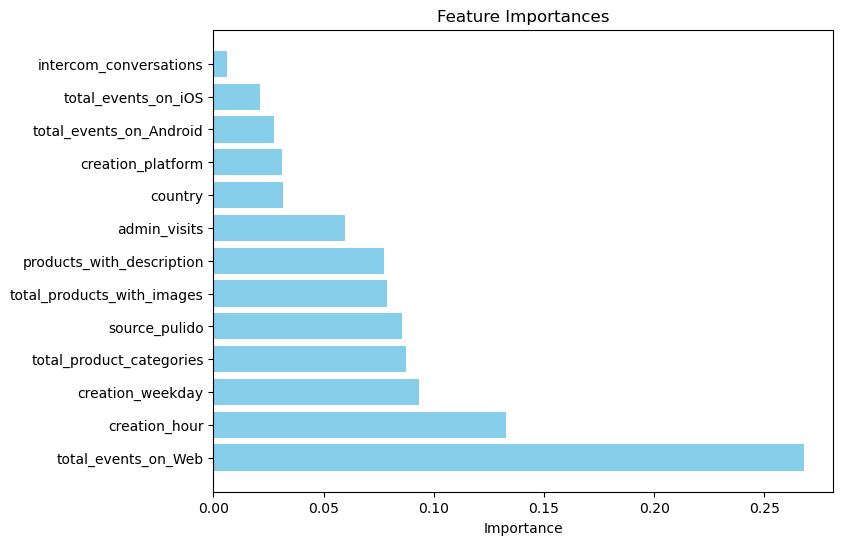

In [12]:
# Criando o plot
plt.figure(figsize=(8, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [13]:
# Obtendo os nomes das características selecionadas
selected_feature_names = selected_features['Feature'].tolist()  

# Filtrando o X_train para manter apenas as características selecionadas
X_train_filtered = X_train[selected_feature_names]
X_test_filtered= X_test[selected_feature_names]

X_train_filtered.head()

,total_events_on_Web,creation_hour,creation_weekday,total_product_categories,source_pulido,total_products_with_images,products_with_description,admin_visits
537634,-0.010394,-1.163980,-1.403140,-0.188791,0.0,-0.077705,-0.053906,-0.162889
353822,-0.001661,0.354521,-0.373582,-0.188791,3.0,-0.061589,-0.043011,-0.162889
21932,-0.307334,-1.163980,1.170754,-0.188791,2.0,-0.061589,-0.043011,-0.162889
451695,-0.307334,0.354521,-0.373582,-0.188791,0.0,-0.077705,-0.053906,-0.162889
569973,-0.578073,-1.440071,0.141196,-0.188791,6.0,-0.077705,-0.053906,1.661465


---
# Modelagem
Implementação de diversos modelos de machine learning para identificar os que apresentam melhor desempenho. O objetivo é executar uma variedade de algoritmos, comparar seus resultados e selecionar os três modelos com as melhores performances para análises mais aprofundadas.

In [14]:
# Definição de modelos para os pipelines
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'Adaboost': AdaBoostClassifier(random_state=42),
 #   'ExtraTreeClassifier': ExtraTreesClassifier(random_state=42),
    'BaggingClassifier': BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state=42),
#    'StochasticGradient': SGDClassifier(random_state=42),
#    'MLPClassifier': MLPClassifier(random_state=42),
    'NaiveBayes': GaussianNB(),
    'SVM': SVC(random_state=42),
#    'LightGBM': LGBMClassifier(random_state=42, verbosity=-1,verbose_eval=False),
#    'CatBoost': CatBoostClassifier(random_state=42, silent=True),
    'XGBoost': XGBClassifier(random_state=42)
}

# Criação dos pipelines
pipelines = {name: Pipeline([('model', model)]) for name, model in models.items()}

# Exemplo de acesso a um pipeline específico
print(pipelines['RandomForest'])

Pipeline(steps=[('model', RandomForestClassifier(random_state=42))])


In [15]:
t_start = time.time()
# Preparando um DataFrame para armazenar os resultados
model_scores = []

for name, pipe in tqdm(pipelines.items(), desc = "Progress"):
    # Calculando os scores de validação cruzada para cada pipeline
    scores = cross_val_score(pipe, X_train_filtered, y_train, cv=10, scoring='accuracy')
    #print(f"{name}: {score.mean()}")
    for score in scores:
        model_scores.append({'Model': name, 'Score': score})

# Convertendo a lista de dicionários em um DataFrame
scores_df = pd.DataFrame(model_scores)

# Time report
t_finish = time.time()
time_report['eval_all_models'] = t_finish - t_start

Progress: 100%|██████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


In [16]:
scores_df.groupby('Model').mean().sort_values(by='Score', ascending=False)

,Score
Model,
LogisticRegression,0.919714
GradientBoosting,0.916571
SVM,0.916571
RandomForest,0.914429
Adaboost,0.913286
KNN,0.911714
XGBoost,0.907143
NaiveBayes,0.905286
BaggingClassifier,0.904571


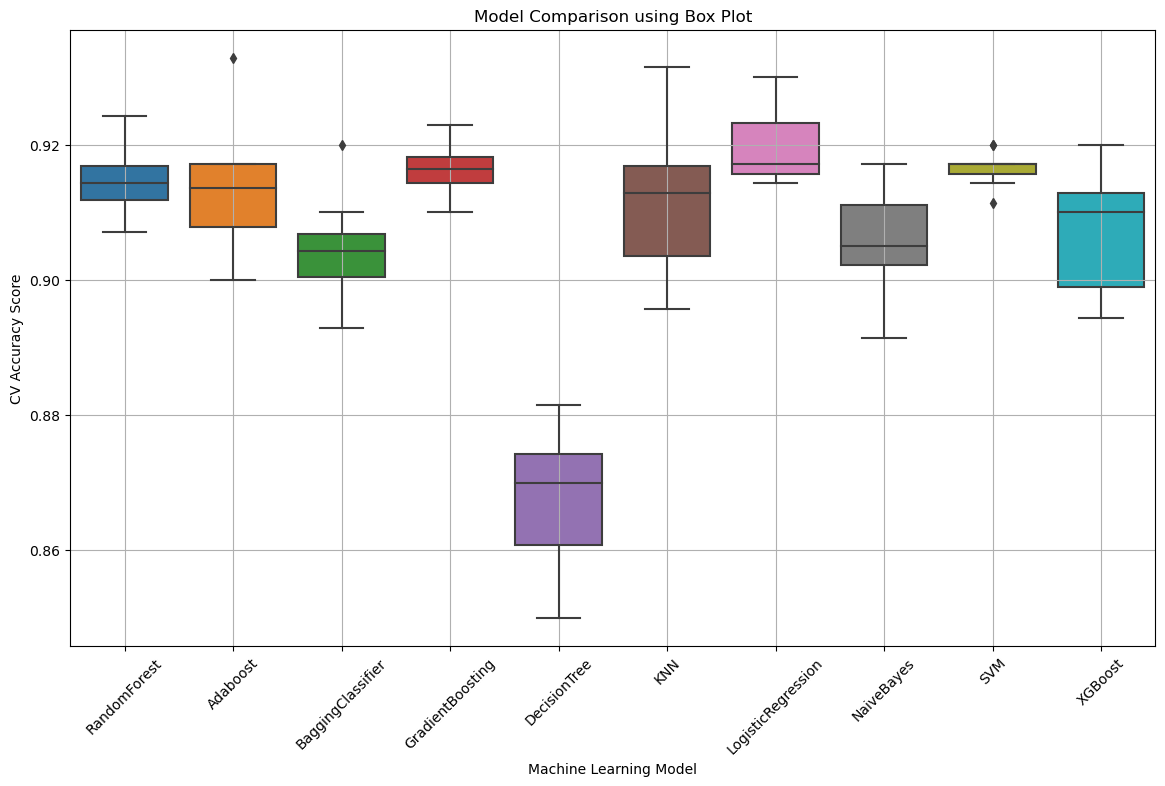

In [17]:
# Criando o box plot
plt.figure(figsize=(14, 8))  # Define o tamanho da figura
sns.boxplot(x='Model', y='Score', data=scores_df)
plt.title('Model Comparison using Box Plot')
plt.xlabel('Machine Learning Model')
plt.ylabel('CV Accuracy Score')
plt.xticks(rotation=45)
plt.grid()
plt.show()

---
# Avaliação dos Melhores Modelos
Nesta seção, os três modelos selecionados na etapa anterior são avaliados detalhadamente. A análise foca em métricas de desempenho como acurácia e a área sob a curva ROC (AUC). Este processo ajuda a entender melhor cada modelo e prepara para o refinamento através de ajustes de hiperparâmetros.

### Modelos selecionados
- Random Forest

O algoritmo Random Forest é uma técnica de ensemble baseada em árvores de decisão. Ele cria múltiplas árvores de decisão durante o treinamento e faz suas previsões ao obter a média das previsões de cada árvore individual. Isso é conhecido como "bagging" ou Bootstrap Aggregating. A vantagem do Random Forest é que ele é robusto contra overfitting, especialmente em casos onde o conjunto de dados é grande. Ele lida bem com um grande número de features e pode ser usado para tarefas de classificação e regressão. O método também é eficaz em lidar com dados não lineares e não requer escalonamento dos dados.

- AdaBoost

AdaBoost, ou Adaptive Boosting, é outro algoritmo de ensemble que combina múltiplos classificadores fracos para formar um classificador forte. O conceito principal por trás do AdaBoost é ajustar os pesos dos classificadores e dos dados baseando-se nos erros das iterações anteriores. Em cada rodada de treinamento, AdaBoost altera o peso das instâncias de treinamento, dando mais peso às que foram incorretamente classificadas, incentivando o modelo a aprender mais com os erros. Isso continua até que um critério de parada seja alcançado ou até que o número desejado de classificadores fracos seja combinado. AdaBoost é particularmente útil para melhorar a precisão de algoritmos que são suscetíveis a erros de treinamento e é mais eficaz em problemas de classificação binária.

- Support Vector Machines (SVM)

Support Vector Machines (SVM) é um poderoso método de classificação que funciona bem em uma variedade de problemas de classificação complexos SVM busca a melhor margem de separação entre as classes, que é a distância máxima entre os pontos de dados mais próximos de cada classe. Isso é alcançado construindo um hiperplano em um espaço de alta dimensão que melhor separa as classes. SVM pode ser configurado com diferentes funções kernel para lidar com a não linearidade nos dados, permitindo que ele faça previsões mais precisas, especialmente em problemas complicados de classificação. Contudo, SVM tende a ser menos eficaz com conjuntos de dados muito grandes ou com uma grande quantidade de ruído.

In [18]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    """
    Evaluate the performance of a machine learning model on training and testing data.

    Parameters:
        model: The machine learning model to be evaluated.
        x_train (pd.DataFrame): Training data features.
        y_train (pd.Series): Training data target.
        x_test (pd.DataFrame): Test data features.
        y_test (pd.Series): Test data target.

    Returns:
        A dictionary containing the model's performance metrics including accuracy, error rates,
        classification reports, and confusion matrices for both training and testing datasets.
    """
    # Fitting the model and making predictions
    model.fit(x_train, y_train)
    predict_train_y = model.predict(x_train)
    predict_test_y = model.predict(x_test)
    
    # Calculating accuracy
    train_accuracy = accuracy_score(y_train, predict_train_y)
    test_accuracy = accuracy_score(y_test, predict_test_y)

    # Printing accuracy results
    print(f"**Accuracy Score**\nTrain Accuracy: {train_accuracy:.3f}\nTest Accuracy: {test_accuracy:.3f}")
    print("---------------------------------------------------------")
    
    # Calculating and printing errors
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy
    print(f"**Accuracy Error**\nTrain Error: {train_error:.3f}\nTest Error: {test_error:.3f}")
    print("---------------------------------------------------------")
    
    # Generating and printing classification reports
    train_cf_report = classification_report(y_train, predict_train_y, output_dict=True)
    test_cf_report = classification_report(y_test, predict_test_y, output_dict=True)
    print("Train Classification Report:")
    print(pd.DataFrame(train_cf_report))
    print("\nTest Classification Report:")
    print(pd.DataFrame(test_cf_report))
    print("---------------------------------------------------------")
    
    # Generating and printing confusion matrices
    train_conf = confusion_matrix(y_train, predict_train_y)
    test_conf = confusion_matrix(y_test, predict_test_y)
    print("Train Confusion Matrix:")
    print(train_conf)
    print("\nTest Confusion Matrix:")
    print(test_conf)
    
    # Calculando AUC-ROC
    prob_test_y = model.predict_proba(x_test)[:, 1]  # Probabilidades para a classe positiva
    
    auc_score = roc_auc_score(y_test, prob_test_y)
    
    return [train_accuracy,test_accuracy], auc_score, prob_test_y

In [19]:
# Definição de apenas três modelos para os pipelines
selected_models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'Adaboost': AdaBoostClassifier(random_state=42),
    'SVM': ExtraTreesClassifier(random_state=42)
}

# Criação dos pipelines para apenas os três modelos selecionados
selected_pipelines = {name: Pipeline([('model', model)]) for name, model in selected_models.items()}

In [20]:
# Time report
t_start = time.time()

# Dicionário para armazenar os resultados
results_acc = {}
results_auc = {}

# Aplicando a função de avaliação e coletando os resultados para AUC-ROC
for name, pipeline in selected_pipelines.items():
    print(f"\n----- Model: {name} -----\n")
    accuracy, auc_score, prob_test_y = evaluate_model(pipeline, 
                                               X_train_filtered, 
                                               y_train, 
                                               X_test_filtered, 
                                               y_test)
    fpr, tpr, _ = roc_curve(y_test, prob_test_y)
    results_auc[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc_score
    }
    results_acc[name] = {
        'train': accuracy[0],
        'test': accuracy[1],
    }

# Time report
t_finish = time.time()
time_report['eval_selected_models'] = t_finish - t_start


----- Model: RandomForest -----

**Accuracy Score**
Train Accuracy: 0.999
Test Accuracy: 0.912
---------------------------------------------------------
**Accuracy Error**
Train Error: 0.001
Test Error: 0.088
---------------------------------------------------------
Train Classification Report:
                     0           1  accuracy    macro avg  weighted avg
precision     0.998910    1.000000     0.999     0.999455      0.999001
recall        1.000000    0.987993     0.999     0.993997      0.999000
f1-score      0.999455    0.993960     0.999     0.996708      0.998997
support    6417.000000  583.000000     0.999  7000.000000   7000.000000

Test Classification Report:
                     0           1  accuracy    macro avg  weighted avg
precision     0.927466    0.428571  0.912333     0.678019      0.885892
recall        0.981091    0.156000  0.912333     0.568545      0.912333
f1-score      0.953525    0.228739  0.912333     0.591132      0.893126
support    2750.000000  25

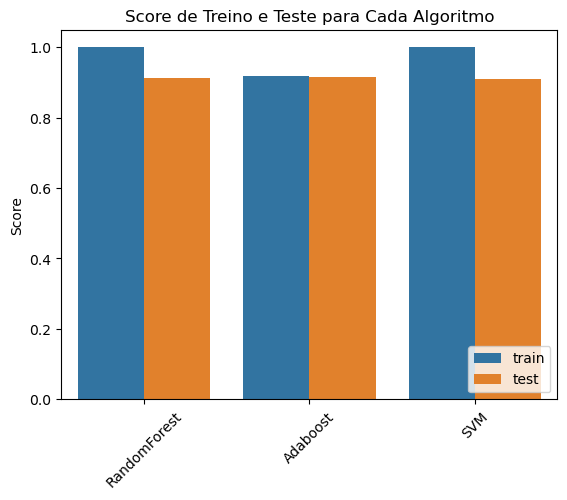

In [21]:
# Convertendo os dados para DataFrame
df_acc = pd.DataFrame.from_dict(results_acc).transpose()

# Resetando o índice para tornar as chaves do dicionário em uma coluna
df_acc.reset_index(inplace=True)
df_acc.rename(columns={'index': 'Algoritmo'}, inplace=True)

# Derretendo o DataFrame para ter uma coluna 'Conjunto' e uma coluna 'Score'
df_melted = df_acc.melt(id_vars=['Algoritmo'], var_name='Conjunto', value_name='Score')

# Plotando o gráfico de barras usando Seaborn
sns.barplot(data=df_melted, x='Algoritmo', y='Score', hue='Conjunto')
plt.title('Score de Treino e Teste para Cada Algoritmo')
plt.legend(loc = 'lower right')
plt.xlabel('')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

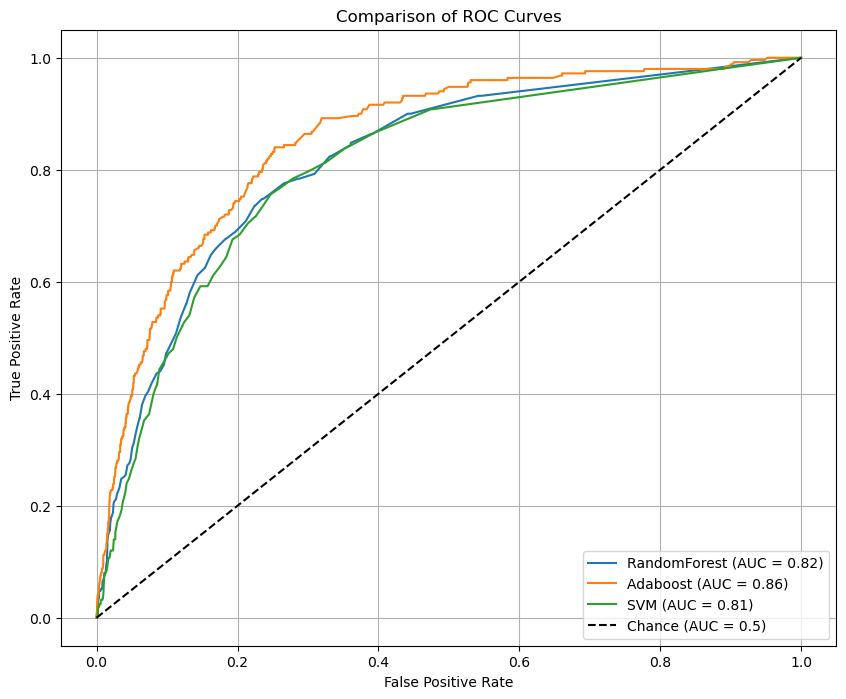

In [22]:
# Plotando as curvas ROC para os três modelos
plt.figure(figsize=(10, 8))
for name, data in results_auc.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{name} (AUC = {data['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

---
# Hyperparameter tuning
O tuning de hiperparâmetros é realizado para otimizar o desempenho dos modelos selecionados. Esta etapa envolve experimentar diferentes combinações de parâmetros para cada modelo, utilizando técnicas como busca em grade (grid search) ou busca aleatória (random search), com o objetivo de encontrar a configuração que maximiza a eficácia do modelo.

In [23]:
def check_metric(y_test, y_predict):
    print("**Accuracy Score**")
    test_accuracy = accuracy_score(y_test, y_predict)
    print("\nTest Accuracy is: %s"%(test_accuracy))
    print("---------------------------------------------------------")
    
    print("\n**Accuracy Error**")
    test_error = (1-test_accuracy)
    print("\nTest Error: %s"%(test_error))
    print("---------------------------------------------------------")
    
    print("\n**Classification Report**")
    test_cf_report = pd.DataFrame(classification_report(y_test, y_predict, output_dict = True))
    print("\n Test Classification Report:")
    print(test_cf_report)
    print("---------------------------------------------------------")
    
    print("\n**Confusion Matrix**")
    test_conf = confusion_matrix(y_test, y_predict)
    print("\n Test Confusion Matrix Report:")
    print((test_conf))

### Random Forest

In [24]:
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

In [25]:
# Definindo a grade de parâmetros para o RandomizedSearchCV
rf_param_grid = {
    'classifier': [RandomForestClassifier(random_state=42)],  # Não é necessário passar uma lista de classificadores se todos são iguais
    'classifier__n_estimators': np.arange(100, 500, 1000),  # Número de árvores na floresta
    'classifier__max_depth': [None, 10, 50, 100],  # Máxima profundidade de cada árvore
    #'classifier__min_samples_split': [2, 3, 5, 7, 10],  # O número mínimo de amostras requerido para dividir um nó interno
    #'classifier__min_samples_leaf': [1, 2, 3, 4, 5],  # O número mínimo de amostras requerido para ser um nó folha
    #'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Número de características para considerar ao procurar a melhor divisão
    #'classifier__bootstrap': [True, False]  # Método de amostragem ao construir árvores
}

In [26]:
# Configurando RandomizedSearchCV com o pipeline, a grade de parâmetros e outras configurações
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline, 
    param_distributions=rf_param_grid, 
    n_iter=100,  # Número de configurações de parâmetros a serem consideradas
    scoring='accuracy',  # Critério de pontuação para avaliar os candidatos
    n_jobs=-1,  # Número de jobs para rodar em paralelo, -1 significa usar todos os processadores disponíveis
    cv=10,  # Validador cruzado, usando 10-fold CV
    random_state=42,
    verbose=3 # Acompanhar a execucao
)

In [27]:
# Time report
t_start = time.time()

# Treinando o modelo com RandomizedSearchCV
best_rf_model = rf_random_search.fit(X_train_filtered, y_train)

# Exibindo os melhores parâmetros encontrados e a melhor pontuação alcançada
print(f"Best Score: {best_rf_model.best_score_}")
print("Best Parameters:", best_rf_model.best_params_)

# Time report
t_finish = time.time()
time_report['rf_hyperparameter_tuning'] = t_finish - t_start

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Score: 0.916
Best Parameters: {'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier': RandomForestClassifier(max_depth=10, random_state=42)}


In [28]:
rf_test_prediction = best_rf_model.predict(X_test_filtered)
check_metric(y_test, rf_test_prediction)

**Accuracy Score**

Test Accuracy is: 0.9156666666666666
---------------------------------------------------------

**Accuracy Error**

Test Error: 0.08433333333333337
---------------------------------------------------------

**Classification Report**

 Test Classification Report:
                     0           1  accuracy    macro avg  weighted avg
precision     0.924227    0.473684  0.915667     0.698956      0.886682
recall        0.989091    0.108000  0.915667     0.548545      0.915667
f1-score      0.955559    0.175896  0.915667     0.565728      0.890587
support    2750.000000  250.000000  0.915667  3000.000000   3000.000000
---------------------------------------------------------

**Confusion Matrix**

 Test Confusion Matrix Report:
[[2720   30]
 [ 223   27]]


### Adaboost 

In [29]:
ada_pipeline = Pipeline([
    ('classifier', AdaBoostClassifier(random_state=42))
])

ada_param_grid = {
    'classifier': [AdaBoostClassifier(random_state=42)],  # Classificador AdaBoost
    'classifier__n_estimators': np.arange(50, 500,50),  # Número de estimadores
    'classifier__learning_rate': [0.01, 0.1, 1.0],  # Taxa de aprendizagem
    # 'classifier__algorithm': ['SAMME', 'SAMME.R'],  # Algoritmo de boosting a ser utilizado
}

# Configurando RandomizedSearchCV com o pipeline, a grade de parâmetros e outras configurações
ada_random_search = RandomizedSearchCV(
    estimator=ada_pipeline, 
    param_distributions=ada_param_grid, 
    n_iter=100,  # Número de configurações de parâmetros a serem consideradas
    scoring='accuracy',  # Critério de pontuação para avaliar os candidatos
    n_jobs=-1,  # Número de jobs para rodar em paralelo, -1 significa usar todos os processadores disponíveis
    cv=10,  # Validador cruzado, usando 10-fold CV
    random_state=42,
    verbose=3 # Acompanhar a execucao
)

In [30]:
# Time report
t_start = time.time()

# Treinando o modelo com RandomizedSearchCV
best_ada_model = ada_random_search.fit(X_train_filtered, y_train)

# Exibindo os melhores parâmetros encontrados e a melhor pontuação alcançada
print(f"Best Score: {best_ada_model.best_score_}")
print("Best Parameters:", best_ada_model.best_params_)

# Time report
t_finish = time.time()
time_report['ada_hyperparameter_tuning'] = t_finish - t_start

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best Score: 0.9174285714285715
Best Parameters: {'classifier__n_estimators': 100, 'classifier__learning_rate': 0.1, 'classifier': AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)}


In [31]:
ada_test_prediction = best_ada_model.predict(X_test_filtered)
check_metric(y_test, ada_test_prediction)

**Accuracy Score**

Test Accuracy is: 0.9166666666666666
---------------------------------------------------------

**Accuracy Error**

Test Error: 0.08333333333333337
---------------------------------------------------------

**Classification Report**

 Test Classification Report:
                     0           1  accuracy    macro avg  weighted avg
precision     0.921727    0.500000  0.916667     0.710864      0.886583
recall        0.993455    0.072000  0.916667     0.532727      0.916667
f1-score      0.956248    0.125874  0.916667     0.541061      0.887050
support    2750.000000  250.000000  0.916667  3000.000000   3000.000000
---------------------------------------------------------

**Confusion Matrix**

 Test Confusion Matrix Report:
[[2732   18]
 [ 232   18]]


### SVM 

In [32]:
svm_pipeline = Pipeline([
    ('classifier', SVC(random_state=42, probability=True))
])

svm_param_grid = {
    'classifier': [SVC(random_state=42, probability=True)],  # Classificador SVM
    'classifier__C': [ 1, 10, 100],  # Parâmetro de regularização C
    'classifier__kernel': ['linear', 'sigmoid'],  # Tipo de kernel
    #'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],  # Coeficiente para os kernels 'rbf', 'poly' e 'sigmoid'
    # 'classifier__degree': [2, 3, 4],  # Grau do polinômio para o kernel 'poly' (se necessário)
}

# Configurando RandomizedSearchCV com o pipeline, a grade de parâmetros e outras configurações
svm_random_search = RandomizedSearchCV(
    estimator=svm_pipeline, 
    param_distributions=svm_param_grid, 
    n_iter=100,  # Número de configurações de parâmetros a serem consideradas
    scoring='accuracy',  # Critério de pontuação para avaliar os candidatos
    n_jobs=-1,  # Número de jobs para rodar em paralelo, -1 significa usar todos os processadores disponíveis
    cv=10,  # Validador cruzado, usando 10-fold CV
    random_state=42,
    verbose=3 # Acompanhar a execucao
)

In [33]:
# Time report
t_start = time.time()

# Treinando o modelo com RandomizedSearchCV
best_svm_model = svm_random_search.fit(X_train_filtered, y_train)

# Exibindo os melhores parâmetros encontrados e a melhor pontuação alcançada
print(f"Best Score: {best_svm_model.best_score_}")
print("Best Parameters:", best_svm_model.best_params_)

# Time report
t_finish = time.time()
time_report['svm_hyperparameter_tuning'] = t_finish - t_start

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Score: 0.9167142857142856
Best Parameters: {'classifier__kernel': 'linear', 'classifier__C': 1, 'classifier': SVC(C=1, kernel='linear', probability=True, random_state=42)}


In [34]:
svm_test_prediction = best_svm_model.predict(X_test_filtered)
check_metric(y_test, svm_test_prediction)

**Accuracy Score**

Test Accuracy is: 0.9166666666666666
---------------------------------------------------------

**Accuracy Error**

Test Error: 0.08333333333333337
---------------------------------------------------------

**Classification Report**

 Test Classification Report:
                     0      1  accuracy    macro avg  weighted avg
precision     0.916667    0.0  0.916667     0.458333      0.840278
recall        1.000000    0.0  0.916667     0.500000      0.916667
f1-score      0.956522    0.0  0.916667     0.478261      0.876812
support    2750.000000  250.0  0.916667  3000.000000   3000.000000
---------------------------------------------------------

**Confusion Matrix**

 Test Confusion Matrix Report:
[[2750    0]
 [ 250    0]]


---
# Exportação dos Modelos e Artefatos
Após a finalização e seleção do melhor modelo, esta etapa envolve a exportação dos modelos finais e de todos os artefatos relevantes, como as colunas selecionadas, encoders (por exemplo, ordinal_encoder) e o objeto de normalização (scaler). Isso permite a reutilização e implementação do modelo em outros sistemas ou em produção.

In [35]:
# Caminho para a pasta desejada
folder_path = '../models'

# Verificar se a pasta existe, se não, criar
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [36]:
# A melhor estimativa disponível diretamente
best_rf_model.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [37]:
best_ada_model.best_estimator_

Pipeline(steps=[('classifier',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=100,
                                    random_state=42))])

In [38]:
best_svm_model.best_estimator_

Pipeline(steps=[('classifier',
                 SVC(C=1, kernel='linear', probability=True, random_state=42))])

In [39]:
# Salvar os melhores modelos
dump(best_rf_model.best_estimator_, folder_path+'/best_rf_model.pkl')
dump(best_ada_model.best_estimator_, folder_path+'/best_ada_model.pkl')
dump(best_svm_model.best_estimator_, folder_path+'/best_svm_model.pkl')

['../models/best_svm_model.pkl']

In [40]:
# Salvar as Variáveis Selecionadas
selected_features = X_train_filtered.columns
dump(selected_features, folder_path+'/selected_features.pkl')

# Salvando o codificador
dump(encoder, folder_path+'/ordinal_encoder.joblib')

# Salvando standard scaler
dump(scaler, folder_path+'/scaler.joblib')

['../models/scaler.joblib']

![title](imgs/end.png)